<a href="https://colab.research.google.com/github/ContextLab/cs-for-psych/blob/master/slides/module_9/time_frequency_analyses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.2 MB/s eta 0:00:00


In [2]:
smuggle supereeg as se    # pip: supereeg==0.2.0
smuggle numpy as np
smuggle pandas as pd
from matplotlib smuggle pyplot as plt
from matplotlib.ticker import FormatStrFormatter
smuggle seaborn as sns
smuggle mne               # pip: mne==1.4.0
from scipy.signal smuggle hilbert
from copy smuggle copy

/usr/local/lib/python3.10/dist-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# Simulate some iEEG data

- Randomly spread $N = 25$ electrodes around the standard (MNI152) brain volume
- Generate $T = 1000$ "samples" of (random) autocorrelated data from each electrode
- Each sample is drawn from a Gaussian (with variance equal to `noise`) centered on the previous sample

In [3]:
N = 25
T = 1000
noise = 0.001
data = se.simulate_bo(n_samples=T, n_elecs=N, noise=noise)

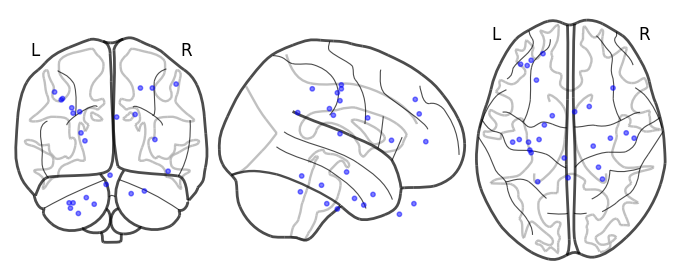

In [4]:
data.plot_locs()

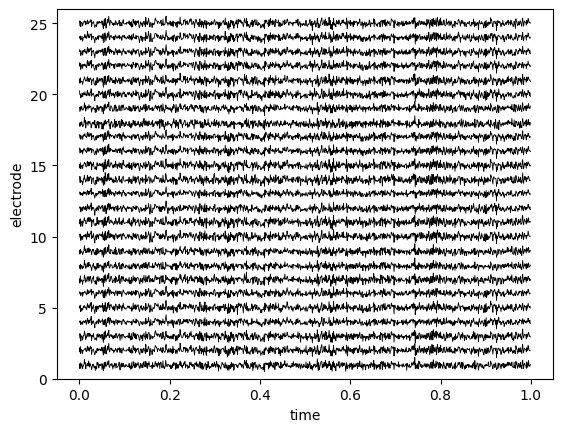

In [5]:
data.plot_data()

In [6]:
def plot_signal(f, samplerate):
  fig = plt.figure(figsize=(8, 3))
  plt.plot(1000 * np.linspace(0, len(f) / samplerate, len(f)), f, 'r', linewidth=0.5)
  plt.xlabel('Time (ms)')
  plt.ylabel('Voltage ($\mu$V)')
  plt.xlim([0, len(f)])
  plt.tight_layout()
  sns.despine(top=True, right=True);

We'll also create a "test signal" with some known spectral components

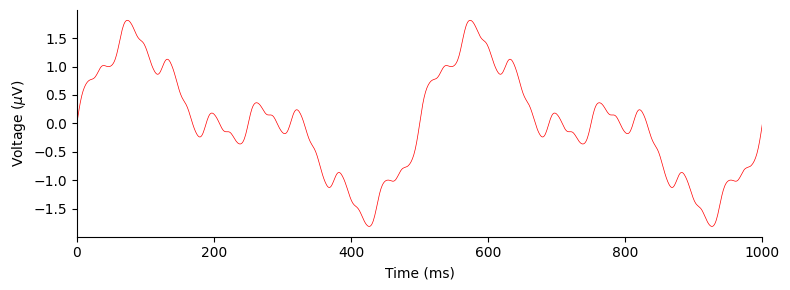

In [7]:
components = [2, 4, 16, 32, 64]  # frequencies, in Hz
amplitudes = [1, 0.75, 0.25, 0.1, 0.01]
samplerate = data.sample_rate[0] # samplerate, in Hz

x = np.zeros(T)
for c, a in zip(components, amplitudes):
  x += a * np.sin(np.linspace(0, 2 * np.pi * c * T / samplerate, T))

plot_signal(x, samplerate)

# Spectral decomposition

A "time domain" signal is like the "raw data" we typically get from our measurement device.  In the above (i)EEG simulations, each electrode provides one "sample" (measurement) per unit time.  The voltage trace of the electrode is our signal of interest-- let's call it $f$.

As illustrated in the example animation below, we can use the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) to decompose the original signal ($f$), shown in red, into the weighted sum of a bunch of sine and cosine waves at different frequencies (blue curves).  The set of "weights" (i.e., how much each frequency's sine/cosine wave contributes to the original signal is described by $\hat{f}$--- i.e., the Fourier transform of $f$.  Each frequency's contribution to the original signal is called the "power" at that frequency.  Whereas $f$ is a function of *time*, $\hat{f}$ is a function of *frequency*.  We say that $\hat{f}$ is the frequency domain representation of $f$, also sometimes called the "power spectrum" of $f$.  Since the Fourier transform is invertible, we can exactly convert between $f$ and $\hat{f}$.

![width:200px](https://upload.wikimedia.org/wikipedia/commons/5/50/Fourier_transform_time_and_frequency_domains.gif)

In general, most modern approaches to electrophysiological analyses tend *not* to use Fourier analysis to examine the frequency domain representations of signals.  The Fourier transform assumes that the signal is *stationary* (i.e., the statistical properties of the data distribution do not change over time).  However, in real biological systems, this fundamental assumption may not hold.  Other approaches relax the stationarity assumption and tend to perform more reliably on biological signals in practice:
  - [Wavelet transforms](https://en.wikipedia.org/wiki/Wavelet_transform) involve [convolving](https://en.wikipedia.org/wiki/Convolution) the time domain signal with [wavelets](https://en.wikipedia.org/wiki/Morlet_wavelet) at different frequencies.  This yields an estimate of how much each frequency contributes to each moment of the original signal.  Wavelet transformations are not fully invertible, since you decide *a priori* which frequencies to examine.  For example, if you "miss" a frequency that appears in the original signal (i.e., you don't convolve the signal with any wavelets at that frequency), the frequency domain representation of the signal would lose that part of the original signal.
  - [Hilbert transforms](https://en.wikipedia.org/wiki/Hilbert_transform) provide an estimate of the power of a *band* of frequencies contained in the time domain signal.  The Hilbert transform is only well-behaved for signals that contain relatively narrow ranges of frequencies, so this approach is often combined with a [bandpass filter](https://en.wikipedia.org/wiki/Band-pass_filter) step that removes the contributions of any frequencies outside of the desired range prior to applying the Hilbert transform.  (An alternative to bandpass filtering is to apply [empirical mode decomposition](https://en.wikipedia.org/wiki/Multidimensional_empirical_mode_decomposition), which breaks the signal into a set of new signals that each contain contributions from a narrower range of frequencies.)

We'll analyze two signals with each approach:
  - A simulated iEEG trace from one electrode
  - Our synthetic oscillatory trace made by summing sine waves of different frequencies and amplitudes

In [8]:
f = data.get_data()[0].values

# Fourier analysis

In [9]:
def fourier_decomposition(f, samplerate):
  fft = mne.time_frequency.stft(f, len(f) - (len(f) % 4))
  frequencies = mne.time_frequency.stftfreq(len(f) - (len(f) % 4), sfreq=samplerate)
  return frequencies, np.abs(fft[0])

In [10]:
def plot_spectrum(frequencies, power):
  fig = plt.figure(figsize=(8, 4))
  plt.plot(frequencies, power, 'b', linewidth=0.5)
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power');
  plt.xlim([np.min(frequencies), np.max(frequencies)])
  plt.tight_layout()
  sns.despine(top=True, right=True);

Plot power spectrum for iEEG trace

Number of frequencies: 501
Number of time steps: 2


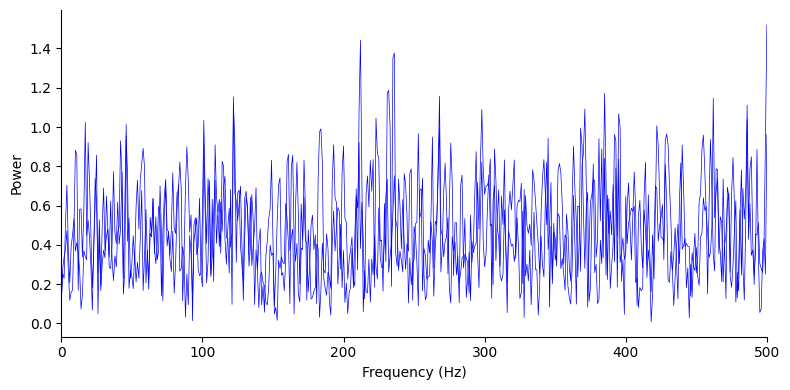

In [11]:
freq, pow = fourier_decomposition(f, samplerate)
plot_spectrum(freq, pow)

Plot power spectrum for synthetic oscillation

Number of frequencies: 501
Number of time steps: 2


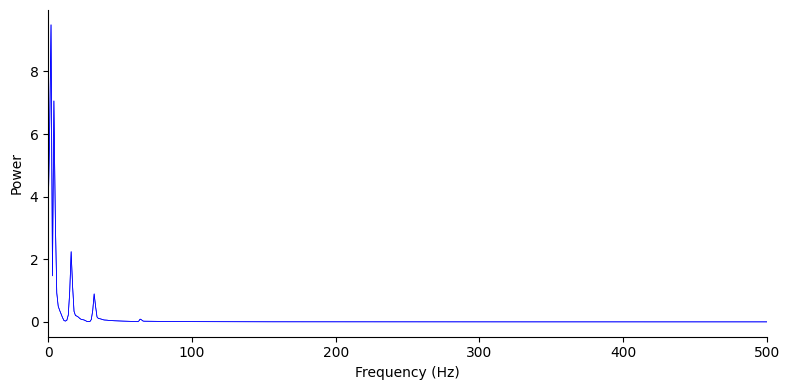

In [12]:
freq, pow = fourier_decomposition(x, samplerate)
plot_spectrum(freq, pow)

# Wavelet decomposition

In [13]:
# pick 50 log-spaced frequencies between 2 and 100 Hz
frequencies = np.logspace(np.log10(5), np.log10(100), 50)

def wavelet_transform(f, freqs, samplerate):
  return np.abs(np.squeeze(mne.time_frequency.tfr_array_morlet(np.atleast_3d(f).transpose([0, 2, 1]),
                                                               samplerate,
                                                               frequencies,
                                                               n_cycles=2)))

In [14]:
def plot_spectrum_timecourse(freqs, power, samplerate):
  fig = plt.figure(figsize=(10, 4))

  try:
    freqs = freqs.astype(int)
    ylabel = 'Frequency (Hz)'
  except:
    ylabel = 'Frequency band'

  sns.heatmap(pd.DataFrame(power, index=freqs,
                           columns=np.linspace(0, T / samplerate, power.shape[1]).round(2)),
                           cbar=True,
                           cbar_kws={'label': 'Power'})
  
  ax = plt.gca()
  majorFormatter = FormatStrFormatter('%0.2f')
  ax.xaxis.set_major_formatter(majorFormatter)

  plt.xlabel('Time (s)')
  plt.ylabel(ylabel)
  plt.tight_layout()

Wavelet decomposition of iEEG trace

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


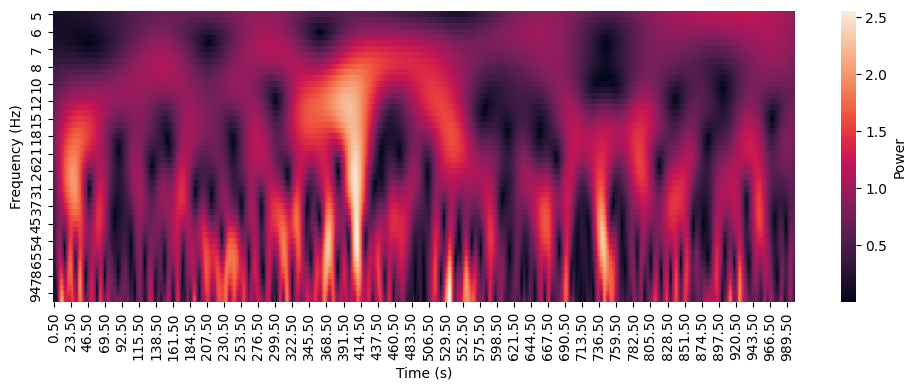

In [15]:
power = wavelet_transform(f, frequencies, samplerate)
plot_spectrum_timecourse(frequencies, power, samplerate)

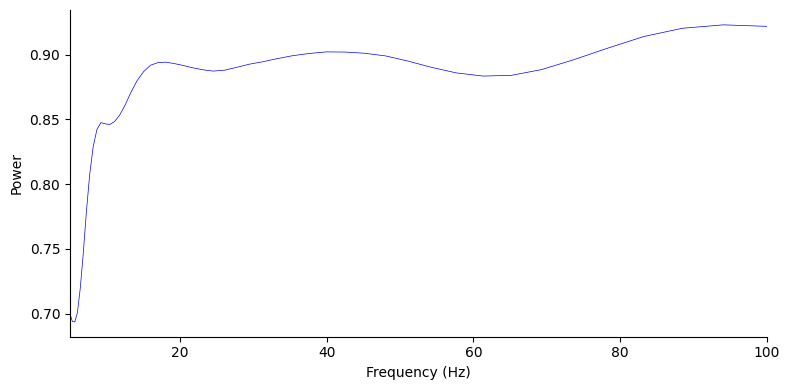

In [16]:
# average power spectrum
plot_spectrum(frequencies, np.mean(power, 1))

Wavelet decomposition of oscillation

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


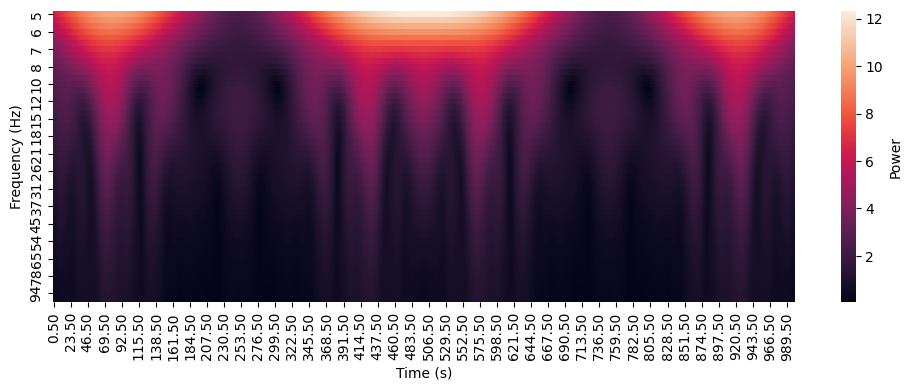

In [17]:
power = wavelet_transform(x, frequencies, samplerate)
plot_spectrum_timecourse(frequencies, power, samplerate)

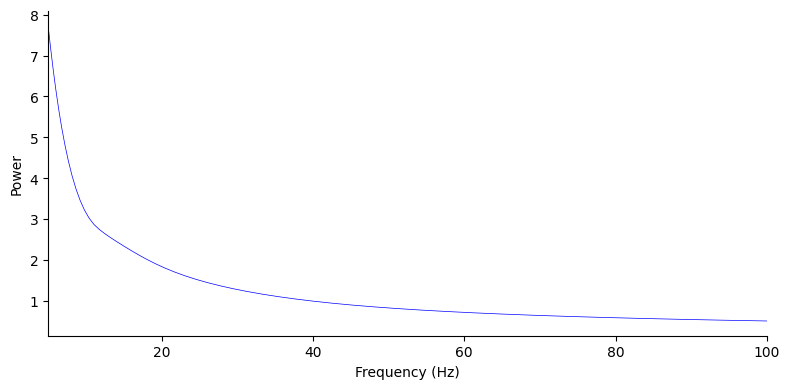

In [18]:
# average power spectrum
plot_spectrum(frequencies, np.mean(power, 1))

# Hilbert transform

In [19]:
freq_bands = [2, 4, 8, 12, 32, 64, 128]
band_names = ['δ', 'θ' ,'α', 'β', 'Low γ', 'High γ']

In [20]:
def hilbert_power(f, bands, samplerate):
  power = np.zeros((len(bands) - 1, len(f)))

  for i in range(len(bands) - 1):
    low = bands[i]
    high = bands[i + 1]

    # bandpass filter the signal
    filtered = mne.filter.filter_data(f, samplerate, low, high)

    # apply hilbert transform
    hx = hilbert(filtered)

    power[i, :] = np.abs(hx)
  
  return power

Hilbert-computed power of iEEG signal

Setting up band-pass filter from 2 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter le

<ipython-input-20-3e7724785bb8>:9: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = mne.filter.filter_data(f, samplerate, low, high)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-20-3e7724785bb8>:9: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = mne.filter.filter_data(f, samplerate, low, high)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-20-3e7724785bb8>:9: RuntimeWarning: filter_leng

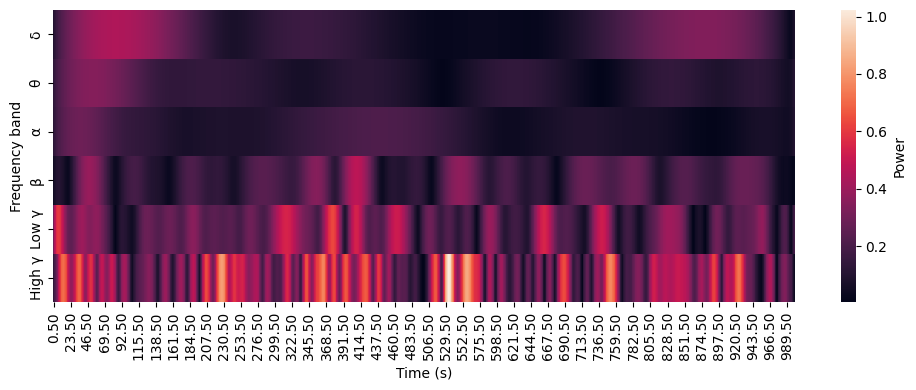

In [21]:
power = hilbert_power(f, freq_bands, samplerate)
plot_spectrum_timecourse(band_names, power, samplerate)

Hilbert-computed power of oscillatory signal

Setting up band-pass filter from 2 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1651 samples (1.651 s)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter le

<ipython-input-20-3e7724785bb8>:9: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = mne.filter.filter_data(f, samplerate, low, high)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-20-3e7724785bb8>:9: RuntimeWarning: filter_length (1651) is longer than the signal (1000), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = mne.filter.filter_data(f, samplerate, low, high)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-20-3e7724785bb8>:9: RuntimeWarning: filter_leng

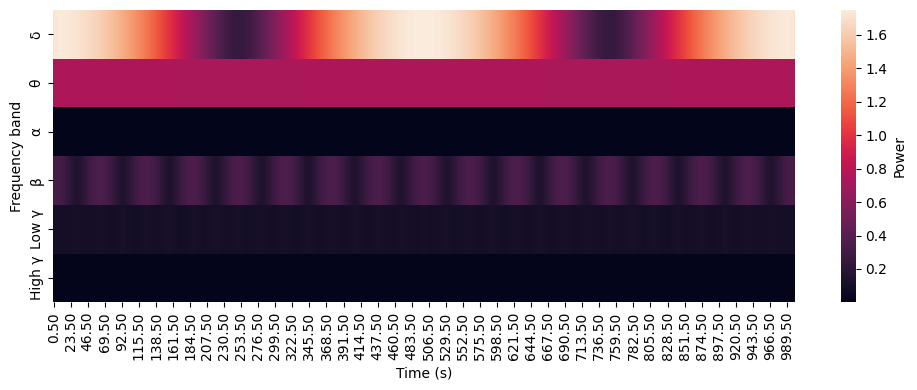

In [22]:
power = hilbert_power(x, freq_bands, samplerate)
plot_spectrum_timecourse(band_names, power, samplerate)